# Data 102 Final Project (Project Group #4)

### Necessary Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from scipy.stats import ttest_ind
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm

### Importing the Data and Cleaning

In [ ]:
state_to_region = {
    "CT": "Northeast", "ME": "Northeast", "MA": "Northeast", "NH": "Northeast",
    "RI": "Northeast", "VT": "Northeast", "NJ": "Northeast", "NY": "Northeast",
    "PA": "Northeast",

    "IL": "Midwest", "IN": "Midwest", "MI": "Midwest", "OH": "Midwest",
    "WI": "Midwest", "IA": "Midwest", "KS": "Midwest", "MN": "Midwest",
    "MO": "Midwest", "NE": "Midwest", "ND": "Midwest", "SD": "Midwest",

    "DE": "South", "FL": "South", "GA": "South", "MD": "South",
    "NC": "South", "SC": "South", "VA": "South", "DC": "South",
    "WV": "South", "AL": "South", "KY": "South", "MS": "South",
    "TN": "South", "AR": "South", "LA": "South", "OK": "South",
    "TX": "South",

    "AZ": "West", "CO": "West", "ID": "West", "MT": "West",
    "NV": "West", "NM": "West", "UT": "West", "WY": "West",
    "AK": "West", "CA": "West", "HI": "West", "OR": "West",
    "WA": "West",

    "PR": "South"
}

In [ ]:
df_0 = pd.read_csv("Subregion_Output_Emission_Rates.csv")
df_1 = pd.read_csv("Subregion_Resource_Mix.csv")
df_2 = pd.read_csv("State_Output_Emission_Rates.csv")
df_3 = pd.read_csv("State_Resource_Mix.csv")

In [ ]:
df_0.columns = [
    "subregion_acronym",
    "subregion_name",

    "total_CO2",
    "total_CH4",
    "total_N2O",
    "total_CO2e",
    "total_annual_NOx",
    "total_ozone_season_NOx",
    "total_SO2",

    "nonbase_CO2",
    "nonbase_CH4",
    "nonbase_N2O",
    "nonbase_CO2e",
    "nonbase_annual_NOx",
    "nonbase_ozone_season_NOx",
    "nonbase_SO2",

    "grid_gross_loss_pct"
]

In [ ]:
renewable_cols = ["Hydro", "Biomass", "Wind", "Solar", "Geo-thermal"]

non_renewable_cols = ["Oil", "Gas", "Other Fossil", "Nuclear", "Other unknown/purchased fuel"]

percent_columns = ['Generation Resource Mix (percent)*', 'Oil', 'Gas', 'Other Fossil',
       'Nuclear', 'Hydro', 'Biomass', 'Wind', 'Solar', 'Geo-thermal',
       'Other unknown/purchased fuel']

comma_columns = ['Nameplate Capacity (MW)', 'Net Generation (MWh)']

quantitative_columns = ['Nameplate Capacity (MW)', 'Net Generation (MWh)', 'Generation Resource Mix (percent)*', 'Oil', 'Gas', 'Other Fossil',
       'Nuclear', 'Hydro', 'Biomass', 'Wind', 'Solar', 'Geo-thermal',
       'Other unknown/purchased fuel']

state_oer_quantitative_columns = ['CO2', 'CH4', 'N20', 'CO2e', 'Annual NOx', 'Ozone Season NOx', 'SO2']

sub_oer_quantitative_columns = ['total_CO2', 'total_CH4',
       'total_N2O', 'total_CO2e', 'total_annual_NOx', 'total_ozone_season_NOx',
       'total_SO2', 'nonbase_CO2', 'nonbase_CH4', 'nonbase_N2O',
       'nonbase_CO2e', 'nonbase_annual_NOx', 'nonbase_ozone_season_NOx',
       'nonbase_SO2', 'grid_gross_loss_pct']

This df has rows that are separated by the eGrid subregions. The columns show the emission rates of various pollutants. These pollutants are split into total output and non-baseload output.

In [ ]:
sub_oer_df = df_0.iloc[2:].reset_index(drop=True)

for each_col in sub_oer_quantitative_columns:
  sub_oer_df[each_col] = sub_oer_df[each_col].str.replace(r"[%\,]", "", regex=True).astype(float)
sub_oer_df['grid_gross_loss_pct'] = sub_oer_df['grid_gross_loss_pct'] / 100

sub_oer_df.head()

,subregion_acronym,subregion_name,total_CO2,total_CH4,total_N2O,total_CO2e,total_annual_NOx,total_ozone_season_NOx,total_SO2,nonbase_CO2,nonbase_CH4,nonbase_N2O,nonbase_CO2e,nonbase_annual_NOx,nonbase_ozone_season_NOx,nonbase_SO2,grid_gross_loss_pct
0,AKGD,ASCC Alaska Grid,899.0,0.086,0.012,904.5,5.6,6.2,0.310,1077.1,0.116,0.016,1084.5,6.3,7.0,0.463,0.041
1,AKMS,ASCC Miscellaneous,519.4,0.026,0.004,521.4,8.1,7.9,0.707,1548.6,0.067,0.012,1553.6,24.4,23.6,2.110,0.041
2,AZNM,WECC Southwest,740.8,0.041,0.006,743.4,0.4,0.4,0.108,1260.4,0.067,0.009,1264.7,0.7,0.6,0.184,0.041
3,CAMX,WECC California,436.7,0.025,0.003,438.2,0.3,0.3,0.020,1034.0,0.051,0.007,1037.1,0.7,0.6,0.045,0.041
4,ERCT,ERCOT All,738.0,0.043,0.006,740.8,0.4,0.5,0.321,1264.9,0.076,0.010,1269.8,0.9,0.9,0.667,0.042


In [ ]:
sub_rm_df = df_1.iloc[1:].reset_index(drop=True)
sub_rm_df = sub_rm_df.rename(columns={'Geo- thermal': 'Geo-thermal', 'Other unknown/ purchased fuel': 'Other unknown/purchased fuel'})
for each_col in quantitative_columns:
  sub_rm_df[each_col] = sub_rm_df[each_col].str.replace(r"[%\,]", "", regex=True).astype(float)
for each_col in percent_columns:
  sub_rm_df[each_col] = sub_rm_df[each_col] / 100

sub_rm_df["Renewable %"] = sub_rm_df[renewable_cols].sum(axis=1)
sub_rm_df["Non-Renewable %"] = sub_rm_df[non_renewable_cols].sum(axis=1)
sub_rm_df

,eGRID subregion acronym,eGRID subregion name,Nameplate Capacity (MW),Net Generation (MWh),Generation Resource Mix (percent)*,Oil,Gas,Other Fossil,Nuclear,Hydro,Biomass,Wind,Solar,Geo-thermal,Other unknown/purchased fuel,Renewable %,Non-Renewable %
0,AKGD,ASCC Alaska Grid,2194.0,5.100447e+06,0.143,0.090,0.604,0.000,0.000,0.139,0.008,0.016,0.000,0.000,0.000,0.163,0.694
1,AKMS,ASCC Miscellaneous,902.0,1.585195e+06,0.000,0.247,0.065,0.000,0.000,0.671,0.000,0.018,0.000,0.000,0.000,0.689,0.312
2,AZNM,WECC Southwest,54243.0,1.667284e+08,0.117,0.000,0.459,0.000,0.189,0.028,0.003,0.081,0.086,0.037,0.000,0.235,0.648
3,CAMX,WECC California,99264.0,2.168418e+08,0.021,0.000,0.411,0.007,0.082,0.147,0.022,0.067,0.205,0.037,0.001,0.478,0.501
4,ERCT,ERCOT All,145508.0,4.744374e+08,0.127,0.000,0.493,0.004,0.086,0.001,0.002,0.227,0.059,0.000,0.001,0.289,0.584
5,FRCC,FRCC All,72774.0,2.440250e+08,0.047,0.005,0.749,0.006,0.123,0.001,0.011,0.000,0.055,0.000,0.004,0.067,0.887
6,HIMS,HICC Miscellaneous,1099.0,2.614533e+06,0.000,0.659,0.000,0.000,0.000,0.036,0.047,0.121,0.064,0.074,0.000,0.342,0.659
7,HIOA,HICC Oahu,2352.0,6.547823e+06,0.000,0.830,0.000,0.027,0.000,0.000,0.025,0.043,0.074,0.000,0.000,0.142,0.857
8,MROE,MRO East,9638.0,2.443890e+07,0.396,0.003,0.427,0.000,0.000,0.043,0.030,0.054,0.047,0.000,0.000,0.174,0.430
9,MROW,MRO West,77432.0,2.409629e+08,0.352,0.001,0.131,0.002,0.078,0.041,0.007,0.376,0.012,0.000,0.001,0.436,0.213


In [ ]:
df_2 = df_2.iloc[2:].reset_index(drop=True)
df_2.columns = ['State', 'CO2', 'CH4', 'N20', 'CO2e', 'Annual NOx', 'Ozone Season NOx', 'SO2']
state_oer_df = df_2.dropna(subset=["State"]).copy()
state_oer_df.loc[:, "Region"] = state_oer_df["State"].map(state_to_region)

for each_col in state_oer_quantitative_columns:
    state_oer_df.loc[:, each_col] = state_oer_df[each_col].str.replace(r"[\,]", "", regex=True).astype(float)



In [ ]:
state_rm_df = df_3.iloc[1:].reset_index(drop=True)
state_rm_df = state_rm_df.rename(columns={'Geo- thermal': 'Geo-thermal', 'Other unknown/ purchased fuel': 'Other unknown/purchased fuel'})
state_rm_df["Region"] = state_rm_df["State"].map(state_to_region)
for each_col in quantitative_columns:
  state_rm_df[each_col] = state_rm_df[each_col].str.replace(r"[%\,]", "", regex=True).astype(float)
for each_col in percent_columns:
  state_rm_df[each_col] = state_rm_df[each_col] / 100

state_rm_df["Renewable %"] = state_rm_df[renewable_cols].sum(axis=1)
state_rm_df["Non-Renewable %"] = state_rm_df[non_renewable_cols].sum(axis=1)
state_rm_df.head()

,State,Nameplate Capacity (MW),Net Generation (MWh),Generation Resource Mix (percent)*,Oil,Gas,Other Fossil,Nuclear,Hydro,Biomass,Wind,Solar,Geo-thermal,Other unknown/purchased fuel,Region,Renewable %,Non-Renewable %
0,AK,3096.0,6685642.0,0.109,0.127,0.476,0.000,0.000,0.265,0.006,0.016,0.000,0.000,0.000,West,0.287,0.603
1,AL,32924.0,138596349.0,0.137,0.000,0.442,0.000,0.329,0.061,0.023,0.000,0.009,0.000,0.000,South,0.093,0.771
2,AR,17060.0,63196142.0,0.267,0.001,0.419,0.000,0.237,0.053,0.011,0.000,0.013,0.000,0.000,South,0.077,0.657
3,AZ,33108.0,102908710.0,0.117,0.000,0.426,0.000,0.306,0.059,0.002,0.017,0.072,0.000,0.000,West,0.150,0.732
4,CA,96731.0,211937397.0,0.001,0.000,0.418,0.007,0.084,0.154,0.024,0.066,0.192,0.053,0.001,West,0.489,0.510


## Data Visualizations

## Quantitative Variable Visualizations (2)

### 1. 2 different scatterplots - Total CO2 emissions vs % of Energy that is Renewable where we plot each state as a data point and then plot each sub region as a data point

In [ ]:
merged_states = pd.merge(state_rm_df, state_oer_df, on='State')
merged_states['Region'] = merged_states['Region_x']
merged_states = merged_states.drop(columns=['Region_x', 'Region_y'])
merged_states.head()

,State,Nameplate Capacity (MW),Net Generation (MWh),Generation Resource Mix (percent)*,Oil,Gas,Other Fossil,Nuclear,Hydro,Biomass,...,Renewable %,Non-Renewable %,CO2,CH4,N20,CO2e,Annual NOx,Ozone Season NOx,SO2,Region
0,AK,3096.0,6685642.0,0.109,0.127,0.476,0.000,0.000,0.265,0.006,...,0.287,0.603,809.0,0.072,0.01,813.6,6.2,6.6,0.404,West
1,AL,32924.0,138596349.0,0.137,0.000,0.442,0.000,0.329,0.061,0.023,...,0.093,0.771,711.0,0.045,0.007,714.0,0.2,0.2,0.093,South
2,AR,17060.0,63196142.0,0.267,0.001,0.419,0.000,0.237,0.053,0.011,...,0.077,0.657,993.4,0.076,0.011,998.4,0.5,0.6,0.857,South
3,AZ,33108.0,102908710.0,0.117,0.000,0.426,0.000,0.306,0.059,0.002,...,0.150,0.732,746.2,0.041,0.006,748.8,0.3,0.3,0.137,West
4,CA,96731.0,211937397.0,0.001,0.000,0.418,0.007,0.084,0.154,0.024,...,0.489,0.510,401.2,0.022,0.003,402.5,0.3,0.3,0.013,West


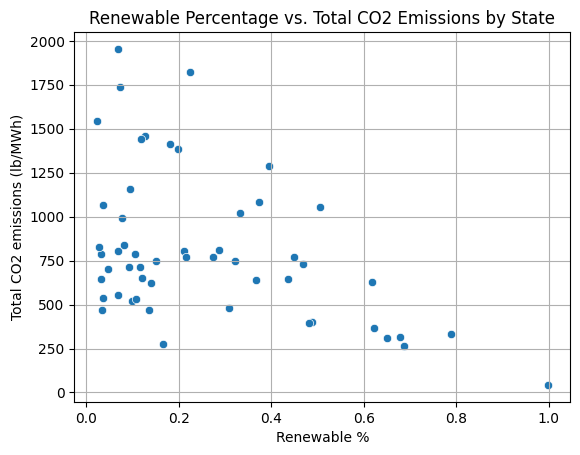

In [ ]:
ax = sns.scatterplot(merged_states, x='Renewable %', y='CO2')
plt.xlabel('Renewable %')
plt.ylabel('Total CO2 emissions (lb/MWh)')
plt.title("Renewable Percentage vs. Total CO2 Emissions by State")
plt.grid(True)
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
plt.show()

In [ ]:
merged_subregions = pd.merge(sub_rm_df, sub_oer_df, right_on='subregion_acronym', left_on='eGRID subregion acronym')
merged_subregions.head()

,eGRID subregion acronym,eGRID subregion name,Nameplate Capacity (MW),Net Generation (MWh),Generation Resource Mix (percent)*,Oil,Gas,Other Fossil,Nuclear,Hydro,...,total_ozone_season_NOx,total_SO2,nonbase_CO2,nonbase_CH4,nonbase_N2O,nonbase_CO2e,nonbase_annual_NOx,nonbase_ozone_season_NOx,nonbase_SO2,grid_gross_loss_pct
0,AKGD,ASCC Alaska Grid,2194.0,5100447.0,0.143,0.090,0.604,0.000,0.000,0.139,...,6.2,0.310,1077.1,0.116,0.016,1084.5,6.3,7.0,0.463,0.041
1,AKMS,ASCC Miscellaneous,902.0,1585195.0,0.000,0.247,0.065,0.000,0.000,0.671,...,7.9,0.707,1548.6,0.067,0.012,1553.6,24.4,23.6,2.110,0.041
2,AZNM,WECC Southwest,54243.0,166728433.0,0.117,0.000,0.459,0.000,0.189,0.028,...,0.4,0.108,1260.4,0.067,0.009,1264.7,0.7,0.6,0.184,0.041
3,CAMX,WECC California,99264.0,216841822.0,0.021,0.000,0.411,0.007,0.082,0.147,...,0.3,0.020,1034.0,0.051,0.007,1037.1,0.7,0.6,0.045,0.041
4,ERCT,ERCOT All,145508.0,474437410.0,0.127,0.000,0.493,0.004,0.086,0.001,...,0.5,0.321,1264.9,0.076,0.010,1269.8,0.9,0.9,0.667,0.042


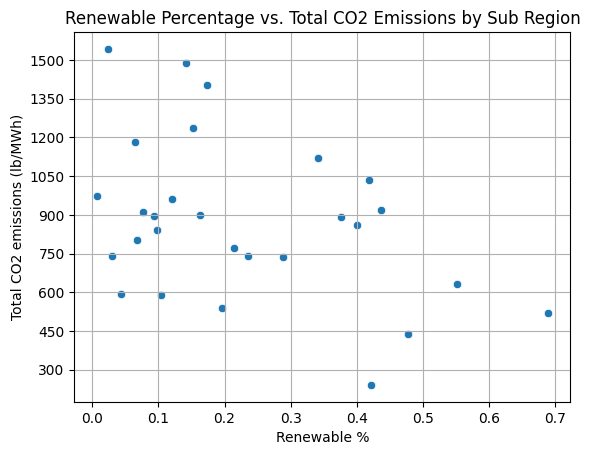

In [ ]:
ax = sns.scatterplot(merged_subregions, x='Renewable %', y='total_CO2')
plt.xlabel('Renewable %')
plt.ylabel('Total CO2 emissions (lb/MWh)')
plt.title("Renewable Percentage vs. Total CO2 Emissions by Sub Region")
plt.grid(True)
ax.yaxis.set_major_locator(MaxNLocator(nbins=10))
plt.show()

For both of these scatterplots, we are observing generally a negative correlation between the percent of energy generated from renewable resources and total CO2 emissions. The relationship is not perfectly linear, but we will begin to account for other factors such as state-size and population in later parts of this project. And regardless, there is a clear downward trend. This helps with our research question because it shows a visible association between renewables and reduced emissions for the causal inference question. This does not prove causality alone but it suggests that we may use renewable percent as a variable and total CO2 as a potential outcome in the causal inference framework.

### 2. Scatterplot for Nameplate Capacity vs. Net Generation (States)

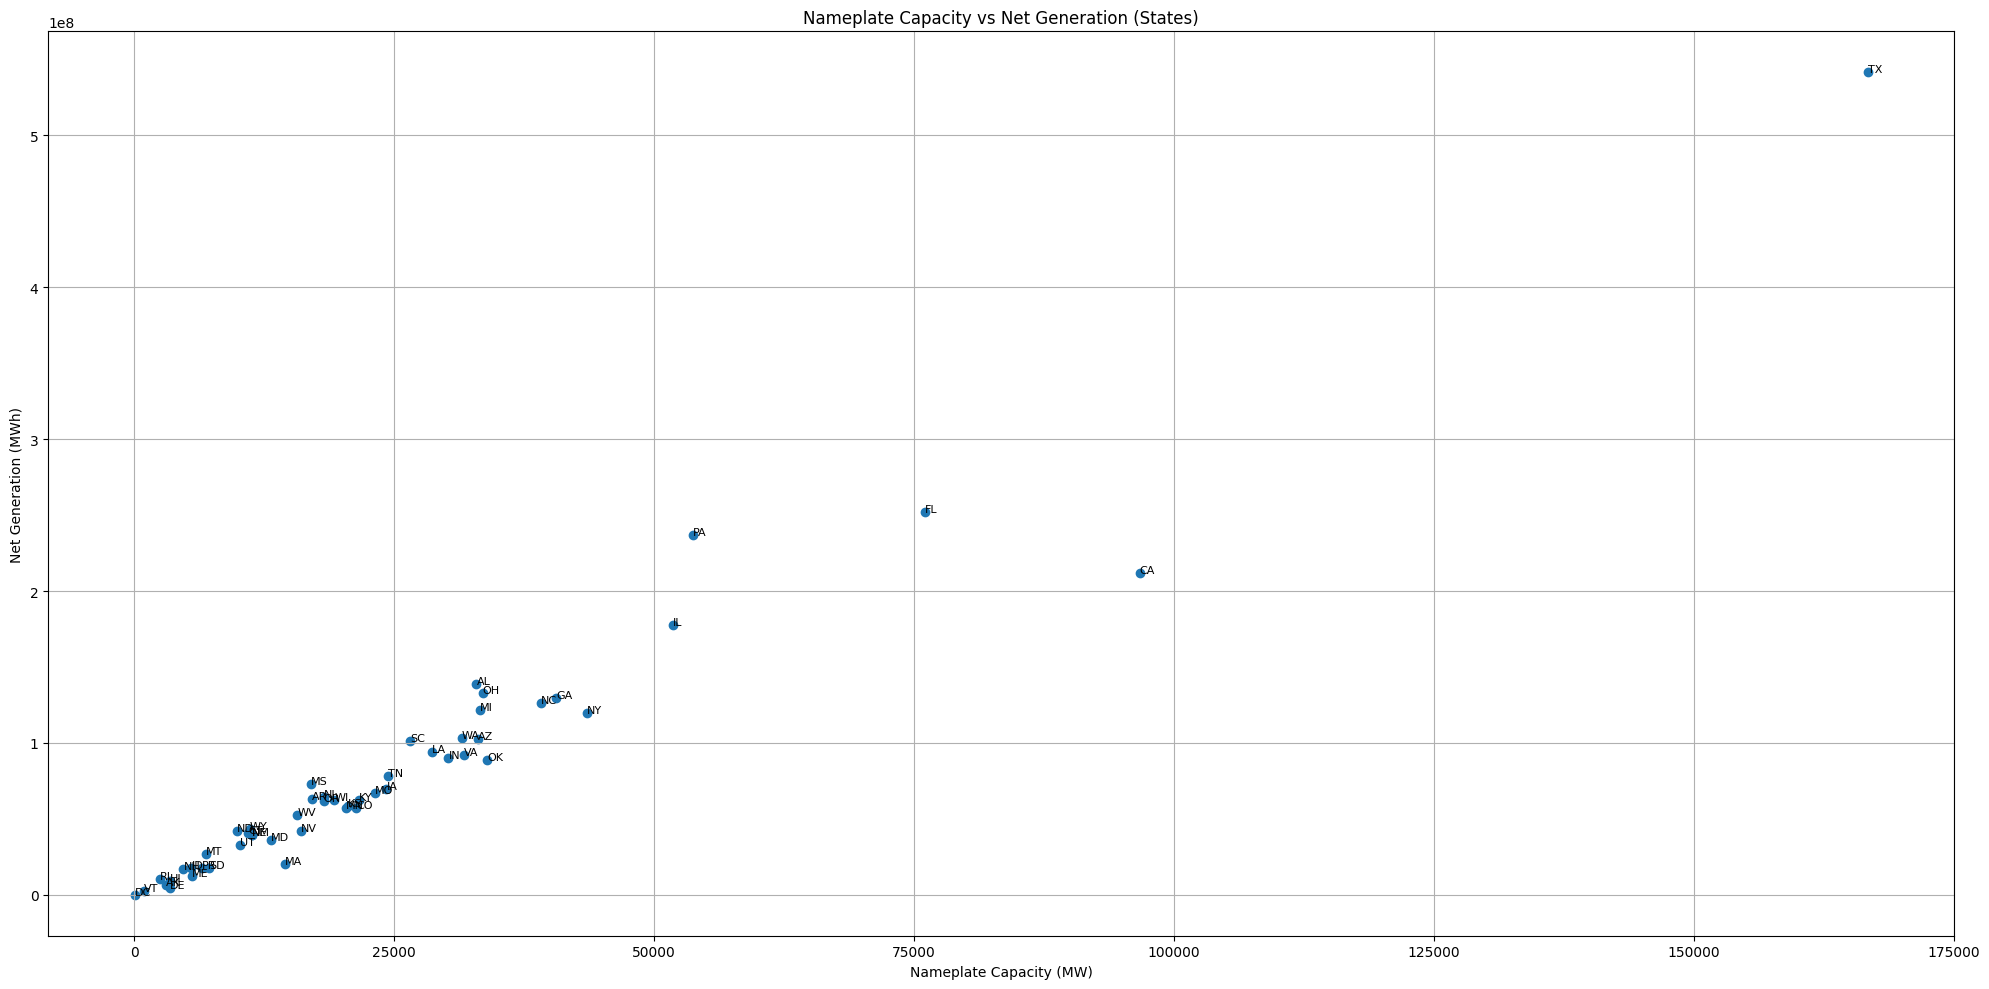

In [ ]:
scatter_data = state_rm_df[['State', 'Nameplate Capacity (MW)', 'Net Generation (MWh)']].copy()

scatter_data['Nameplate Capacity (MW)'] = scatter_data['Nameplate Capacity (MW)'].replace(',', '', regex=True)
scatter_data['Net Generation (MWh)'] = scatter_data['Net Generation (MWh)'].replace(',', '', regex=True)

scatter_data['Nameplate Capacity (MW)'] = pd.to_numeric(scatter_data['Nameplate Capacity (MW)'], errors='coerce')
scatter_data['Net Generation (MWh)'] = pd.to_numeric(scatter_data['Net Generation (MWh)'], errors='coerce')

scatter_data = scatter_data[scatter_data['State'] != 'U.S.']

scatter_data = scatter_data.dropna()

plt.figure(figsize=(20, 10))
plt.scatter(scatter_data['Nameplate Capacity (MW)'], scatter_data['Net Generation (MWh)'])
plt.title('Nameplate Capacity vs Net Generation (States)')
plt.xlabel('Nameplate Capacity (MW)')
plt.ylabel('Net Generation (MWh)')
plt.grid(True)

for i, row in scatter_data.iterrows():
    plt.text(row['Nameplate Capacity (MW)'], row['Net Generation (MWh)'], row['State'], fontsize=8)

plt.tight_layout()
plt.show()

What this plot shows is on our x axis, we have the maximum capacity of energy a state could produce while our y axis is actually how much a state produces. This plot can show us which states produce more or less energy for the US which can then be correlated with states who also produce more carbon emissions.

### Categorical Variable Visualizations (2)

### 3. Bar plot - Number of states with a relatively high percentage of renewable energy in their resource mix, grouped by region.

In [ ]:
state_rm_df["Renewable %"] = pd.to_numeric(state_rm_df["Renewable %"], errors="coerce")
state_rm_df["Non-Renewable %"] = pd.to_numeric(state_rm_df["Non-Renewable %"], errors="coerce")

median_renewable = state_rm_df["Renewable %"].median()
median_nonrenewable = state_rm_df["Non-Renewable %"].median()

state_rm_df["Renewable Group"] = state_rm_df["Renewable %"].apply(
    lambda x: 1 if x >= median_renewable else 0
)

state_rm_df["Renewable Group"] = pd.to_numeric(state_rm_df["Renewable Group"], errors="coerce").astype("Int64")

state_rm_df.head()

,State,Nameplate Capacity (MW),Net Generation (MWh),Generation Resource Mix (percent)*,Oil,Gas,Other Fossil,Nuclear,Hydro,Biomass,Wind,Solar,Geo-thermal,Other unknown/purchased fuel,Region,Renewable %,Non-Renewable %,Renewable Group
0,AK,3096.0,6685642.0,0.109,0.127,0.476,0.000,0.000,0.265,0.006,0.016,0.000,0.000,0.000,West,0.287,0.603,1
1,AL,32924.0,138596349.0,0.137,0.000,0.442,0.000,0.329,0.061,0.023,0.000,0.009,0.000,0.000,South,0.093,0.771,0
2,AR,17060.0,63196142.0,0.267,0.001,0.419,0.000,0.237,0.053,0.011,0.000,0.013,0.000,0.000,South,0.077,0.657,0
3,AZ,33108.0,102908710.0,0.117,0.000,0.426,0.000,0.306,0.059,0.002,0.017,0.072,0.000,0.000,West,0.150,0.732,0
4,CA,96731.0,211937397.0,0.001,0.000,0.418,0.007,0.084,0.154,0.024,0.066,0.192,0.053,0.001,West,0.489,0.510,1


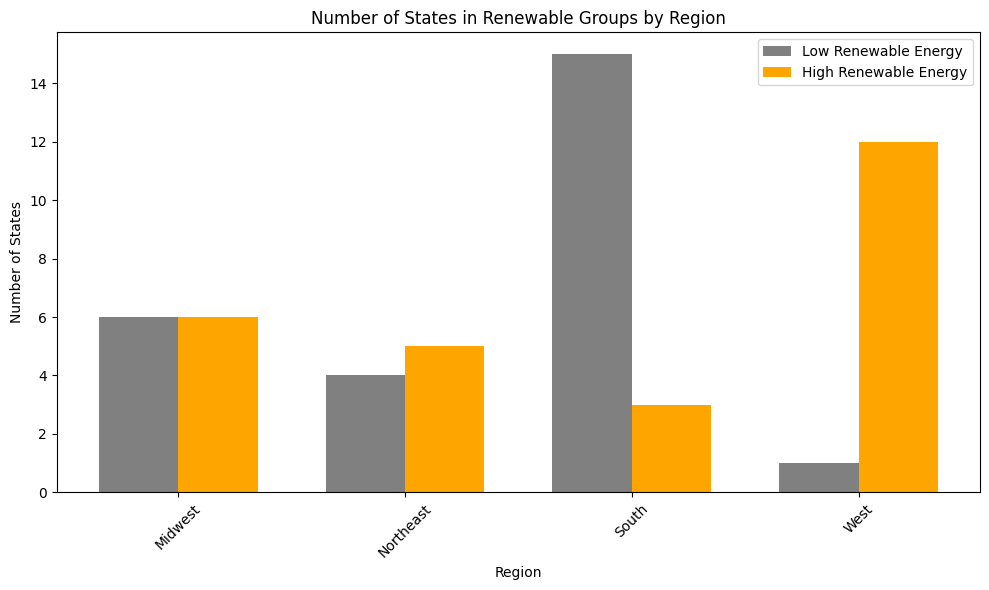

In [ ]:
plot_df = state_rm_df.dropna(subset=["Renewable Group", "Region"])

grouped_counts = plot_df.groupby(["Region", "Renewable Group"]).size().unstack(fill_value=0)

if 0 not in grouped_counts.columns:
    grouped_counts[0] = 0
if 1 not in grouped_counts.columns:
    grouped_counts[1] = 0

grouped_counts = grouped_counts[[0, 1]]

regions = grouped_counts.index
x = np.arange(len(regions))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

bar_low = ax.bar(x - width/2, grouped_counts[0], width, label="Low Renewable Energy", color="gray")
bar_high = ax.bar(x + width/2, grouped_counts[1], width, label="High Renewable Energy", color="orange")

ax.set_xlabel("Region")
ax.set_ylabel("Number of States")
ax.set_title("Number of States in Renewable Groups by Region")
ax.set_xticks(x)
ax.set_xticklabels(regions, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

The double bar graph shows that West have a high number of states that has high renewable energy percentage of their resource mix, while regions like the South have more states that has low renewable energy percentage. This regional contrast may reflect policy, geographic, or infrastructure differences in renewable adoption. These patterns are directly relevant to our research question because they suggest that emission rates may also vary by region through their renewable energy usage. If states with more renewable energy have lower emissions, this could point to a significant relationship worth testing statistically. This motivates our hypothesis and can guide which regions may benefit most from renewable energy incentives or emission-reduction efforts.

### 4. Bar Plot - Sub Regions ranked by Total CO2 Emissions

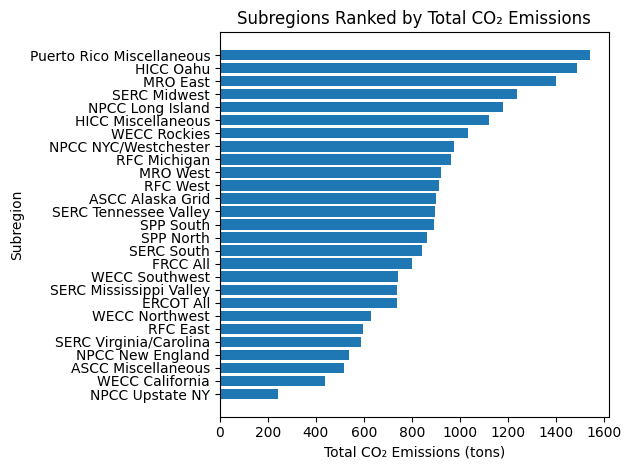

In [ ]:
co2_emissions = sub_oer_df[['subregion_name', 'total_CO2']].copy()

co2_emissions.loc[:, 'total_CO2'] = pd.to_numeric(co2_emissions['total_CO2'], errors='coerce')

co2_emissions = co2_emissions.dropna(subset=['subregion_name', 'total_CO2'])

co2_emissions_sorted = co2_emissions.sort_values(by='total_CO2', ascending=True)

plt.barh(co2_emissions_sorted['subregion_name'], co2_emissions_sorted['total_CO2'])
plt.title('Subregions Ranked by Total CO₂ Emissions')
plt.xlabel('Total CO₂ Emissions (tons)')
plt.ylabel('Subregion')
plt.tight_layout()
plt.show()


As shown in this bar plot, we can see that we are mapping all subregions vs their total CO_2 Emissions per ton. What we can extract from this is which regions are high produces vs which regions are low producers. As we can see NYC and Michigan stands as the two highest producers of total CO_2 emissions while upstate NY and California are the lowest contributors of CO_2 emissions. This helps support our research question as it shows how different subregions even in the same state like NY can have wildly different CO_2 emissions based on just location in the state alone.

## Research Question #1 Results (Multiple hypothesis testing / decision making)
Test at least six different hypotheses, correctly calculating p-values for each one, and use two different multiple hypothesis testing correction techniques to control error rates.

Question: Are there statistically significant differences in emission rates between states with high vs. low proportions of renewable energy in their resource mix?

### Hypothesis 1:
States that have 30% or more renewable energy have lower CO2 emissions than states with 30% or less renewable energy.



In [ ]:

merged_states['Renewable %'] = pd.to_numeric(merged_states['Renewable %'], errors='coerce')

high_renew = pd.to_numeric(merged_states[merged_states["Renewable %"] >= 0.30]['CO2'])
low_renew = pd.to_numeric(merged_states[merged_states["Renewable %"] <= 0.30]['CO2'])

t_stat, p_value = ttest_ind(high_renew, low_renew, equal_var=False, alternative='less')

print(f"t-statistics: {t_stat}")
print(f"p-value: {p_value}")

mean1 = np.mean(high_renew)
mean2 = np.mean(low_renew)
std1 = np.std(high_renew, ddof=1)
std2 = np.std(low_renew, ddof=1)

n_high = len(high_renew)
n_low = len(low_renew)
pooled_std = np.sqrt((std1**2 + std2**2) / 2)

cohen_d = (mean1 - mean2) / pooled_std

alpha = 0.05
analysis = TTestIndPower()
power = analysis.power(effect_size=cohen_d, nobs1=n_high, ratio=n_low/n_high, alpha=alpha, alternative='smaller')

print(f"Power: {power}")

t-statistics: -2.9890202065865044
p-value: 0.0022514945248600596
Power: 0.8848185898726098


### Hypothesis 2
States that rely on gas (more than 40%) have generally higher CO2 emissions than states that do not.

In [ ]:

merged_states['Gas'] = pd.to_numeric(merged_states['Gas'], errors='coerce')
merged_states['CO2'] = pd.to_numeric(merged_states['CO2'], errors='coerce')

high_gas = merged_states[merged_states['Gas'] >= 0.40]['CO2']
low_gas = merged_states[merged_states['Gas'] <= 0.40]['CO2']

high_gas.head()
t_stat, p_value = ttest_ind(high_gas, low_gas, equal_var=False)

print(f"t-statistics: {t_stat}")
print(f"p-value: {p_value}")

t-statistics: -1.2081916991298165
p-value: 0.23579771129620003


### Hypothesis 3
States where wind and solar together make up more than 20% of the energy mix have lower CO2 emissions than states with 20% or less from wind and solar.

In [ ]:
# Hypothesis 3 - Lucas Czajka

merged_states['Wind'] = pd.to_numeric(merged_states['Wind'], errors='coerce')
merged_states['Solar'] = pd.to_numeric(merged_states['Solar'], errors='coerce')
merged_states['CO2e'] = pd.to_numeric(merged_states['CO2e'], errors='coerce')

merged_states['Wind_Solar_Percentage'] = merged_states['Wind'] + merged_states['Solar']

high_renewable_states = merged_states[merged_states['Wind_Solar_Percentage'] > 0.20]
low_renewable_states = merged_states[merged_states['Wind_Solar_Percentage'] <= 0.20]

high_renewable_emissions = high_renewable_states['CO2e']
low_renewable_emissions = low_renewable_states['CO2e']

t_stat, p_value = ttest_ind(high_renewable_emissions.dropna(), low_renewable_emissions.dropna(), equal_var=False)

print(f"t-statistics: {t_stat}")
print(f"p-value: {p_value}")




t-statistics: -0.6184127505737442
p-value: 0.541927830262319


### Hypothesis 4a and 4b
4a) Subregions where Oil + Gas + Other Fossil make up 70% or more of the generation mix have higher total ozone season NOx and SO2 emissions than subregions with less fossil generation.

4b) Subregions where Oil + Gas + Other Fossil make up 70% or more of the generation mix have higher total ozone season NOx and SO2 emissions than subregions with less fossil generation.

In [ ]:
merged_subregions['Fossil_Percentage'] = merged_subregions['Oil'] + merged_subregions['Gas'] + merged_subregions['Other Fossil']

high_fossil_subregions = merged_subregions[merged_subregions['Fossil_Percentage'] >= 0.70]
low_fossil_subregions = merged_subregions[merged_subregions['Fossil_Percentage'] < 0.70]

high_fossil_NOx = high_fossil_subregions['total_ozone_season_NOx']
low_fossil_NOx = low_fossil_subregions['total_ozone_season_NOx']

high_fossil_SO2 = high_fossil_subregions['total_SO2']
low_fossil_SO2 = low_fossil_subregions['total_SO2']
t_stat_NOx, p_value_NOx = ttest_ind(high_fossil_NOx.dropna(), low_fossil_NOx.dropna(), equal_var=False)
t_stat_SO2, p_value_SO2 = ttest_ind(high_fossil_SO2.dropna(), low_fossil_SO2.dropna(), equal_var=False)
print(f"NOx t-statistics: {t_stat_NOx}, p-value: {p_value_NOx}")
print(f"SO2 t-statistics: {t_stat_SO2}, p-value: {p_value_SO2}")


NOx t-statistics: 0.48918324698215265, p-value: 0.6401282037489531
SO2 t-statistics: 1.1747158454827067, p-value: 0.3005136057713355


### Hypothesis 5
Subregions with a more balanced energy mix have higher net generation than regions with high renewable energy (testing Midwest/Northeast vs West).


In [ ]:
merged_states["Net Generation (MWh)"] = pd.to_numeric(merged_states["Net Generation (MWh)"], errors="coerce")

high_GRM = merged_states[merged_states['Generation Resource Mix (percent)*']> .18]
low_GRM = merged_states[merged_states['Generation Resource Mix (percent)*']<= .18]

group_1 = high_GRM[high_GRM["Region"] == "West"]
group_2 = low_GRM[low_GRM["Region"] == "South"]

group_1_generation = group_1["Net Generation (MWh)"]
group_2_generation = group_2["Net Generation (MWh)"]

t_stat_gen, p_value_gen = ttest_ind(group_1_generation.dropna(), group_2_generation.dropna(), equal_var=False)

print(f"Net Generation t-statistic: {t_stat_gen}")
print(f"p-value: {p_value_gen}")

Net Generation t-statistic: -2.189128157165816
p-value: 0.04669241542285669


# Hypothesis 6
The West has lower CO2 emissions than the South.

In [ ]:
merged_states['CO2'] = pd.to_numeric(merged_states['CO2'], errors='coerce')

west_emissions = merged_states[merged_states["Region"] == "West"]["CO2"]
south_emissions = merged_states[merged_states["Region"] == "South"]["CO2"]

t_stat, p_value = ttest_ind(west_emissions, south_emissions, equal_var=False, alternative='less')

print(f"t-statistics: {t_stat}")
print(f"p-value: {p_value}")


t-statistics: -0.04559781895936154
p-value: 0.4820012381382627


### Hypothesis 7-13
There are higher emission rates in the lower quartile of U.S. states regarding renewable energy in their resource mix compared to the upper quartile. Each hypothesis from 7 to 13 will focus on a specific type of emission:

Hypothesis 7: Carbon dioxide (CO2)

Hypothesis 8: Methane (CH4)

Hypothesis 9: Nitrous oxide (N20)

Hypothesis 10: Carbone dioxide equivlant (CO2e)

Hypothesis 11: Annual Nitrogen Oxides (NOx)

Hypothesis 12: Ozone Season Nitrogen Oxides (NOx)

Hypothesis 13: Sulfur Dioxide (SO2)

In [ ]:
merged_states_only = merged_states.iloc[:-1]
renewable_sorted_merged_states_only = merged_states_only.sort_values(by='Renewable %', ascending=False)
renewable_top13 = renewable_sorted_merged_states_only.head(13).dropna()
renewable_bottom13 = renewable_sorted_merged_states_only.tail(13).dropna()

from scipy.stats import ttest_ind
import pandas as pd

hypothesis_7_emission = 'CO2'

co2_high_emission = pd.to_numeric(renewable_top13[hypothesis_7_emission].dropna())
co2_low_emission = pd.to_numeric(renewable_bottom13[hypothesis_7_emission].dropna())

t_stat_7, p_value_7 = ttest_ind(co2_high_emission, co2_low_emission, equal_var=False, alternative='less')

print(f"CO2 - t-statistics: {t_stat_7}")
print(f"CO2 - p-value: {p_value_7}")

hypothesis_8_emission = 'CH4'

ch4_high_emission = pd.to_numeric(renewable_top13[hypothesis_8_emission].dropna())
ch4_low_emission = pd.to_numeric(renewable_bottom13[hypothesis_8_emission].dropna())

t_stat_8, p_value_8 = ttest_ind(ch4_high_emission, ch4_low_emission, equal_var=False, alternative='less')

print(f"CH4 - t-statistics: {t_stat_8}")
print(f"CH4 - p-value: {p_value_8}")

hypothesis_9_emission = 'N20'

n20_high_emission = pd.to_numeric(renewable_top13[hypothesis_9_emission].dropna())
n20_low_emission = pd.to_numeric(renewable_bottom13[hypothesis_9_emission].dropna())

t_stat_9, p_value_9 = ttest_ind(n20_high_emission, n20_low_emission, equal_var=False, alternative='less')

print(f"N2O - t-statistics: {t_stat_9}")
print(f"N2O - p-value: {p_value_9}")

hypothesis_10_emission = 'CO2e'

co2e_high_emission = pd.to_numeric(renewable_top13[hypothesis_10_emission].dropna())
co2e_low_emission = pd.to_numeric(renewable_bottom13[hypothesis_10_emission].dropna())

t_stat_10, p_value_10 = ttest_ind(co2e_high_emission, co2e_low_emission, equal_var=False, alternative='less')

print(f"CO2e - t-statistics: {t_stat_10}")
print(f"CO2e - p-value: {p_value_10}")

hypothesis_11_emission = 'Annual NOx'

annual_nox_high_emission = pd.to_numeric(renewable_top13[hypothesis_11_emission].dropna())
annual_nox_low_emission = pd.to_numeric(renewable_bottom13[hypothesis_11_emission].dropna())

t_stat_11, p_value_11 = ttest_ind(annual_nox_high_emission, annual_nox_low_emission, equal_var=False, alternative='less')

print(f"Annual NOx - t-statistics: {t_stat_11}")
print(f"Annual NOx - p-value: {p_value_11}")

hypothesis_12_emission = 'Ozone Season NOx'

ozone_season_nox_high_emission = pd.to_numeric(renewable_top13['Ozone Season NOx'].dropna())
ozone_season_nox_low_emission = pd.to_numeric(renewable_bottom13['Ozone Season NOx'].dropna())

t_stat_12, p_value_12 = ttest_ind(ozone_season_nox_high_emission, ozone_season_nox_low_emission, equal_var=False, alternative='less')

print(f"Ozone Season NOx - t-statistics: {t_stat_12}")
print(f"Ozone Season NOx - p-value: {p_value_12}")

hypothesis_13_emission = 'SO2'

so2_high_emission = pd.to_numeric(renewable_top13['SO2'].dropna())
so2_low_emission = pd.to_numeric(renewable_bottom13['SO2'].dropna())

t_stat_13, p_value_13 = ttest_ind(so2_high_emission, so2_low_emission, equal_var=False, alternative='less')

print(f"SO2 - t-statistics: {t_stat_13}")
print(f"SO2 - p-value: {p_value_13}")



# Putting it all together into one:

results = []
for emission in ["CO2", "CH4", "N20", "CO2e", "Annual NOx", "Ozone Season NOx", "SO2"]:
    high_emission = pd.to_numeric(renewable_top13[emission].dropna())
    low_emission = pd.to_numeric(renewable_bottom13[emission].dropna())
    t_stat, p_value = ttest_ind(high_emission, low_emission, equal_var=False, alternative='less')
    results.append((emission, t_stat, p_value))

results_df = pd.DataFrame(results, columns=["Emission Type", "t-statistic", "Raw p-value"])

results_df

CO2 - t-statistics: -3.2037855915818967
CO2 - p-value: 0.002352537974043445
CH4 - t-statistics: -0.830533530295012
CH4 - p-value: 0.2076950977514867
N2O - t-statistics: -0.8859103564339605
N2O - p-value: 0.19293437599267876
CO2e - t-statistics: -3.190959341503058
CO2e - p-value: 0.002428837466649518
Annual NOx - t-statistics: -0.38441604358144205
Annual NOx - p-value: 0.35223398636976894
Ozone Season NOx - t-statistics: -0.4621061891846375
Ozone Season NOx - p-value: 0.32464183560053106
SO2 - t-statistics: -1.7546870694952028
SO2 - p-value: 0.0511694199427553


,Emission Type,t-statistic,Raw p-value
0,CO2,-3.203786,0.002353
1,CH4,-0.830534,0.207695
2,N20,-0.885910,0.192934
3,CO2e,-3.190959,0.002429
4,Annual NOx,-0.384416,0.352234
5,Ozone Season NOx,-0.462106,0.324642
6,SO2,-1.754687,0.051169


## Method 1 for Correcting Bonferroni

In [ ]:
from statsmodels.stats.multitest import multipletests

pvals = [0.002, 0.235, 0.541, 0.640, 0.300, 0.136, 0.482, 0.002353	, 0.207, 0.19234, 0.002429, 0.352234, 0.324642, 0.051169]

corrected = multipletests(pvals, method='bonferroni')
corrected_pvals = corrected[1]

alpha = 0.05

significant = corrected_pvals < alpha

results_1=[]
for i, (raw_p, adj_p, is_sig) in enumerate(zip(pvals, corrected_pvals, significant)):
    results_1.append((f"Hypothesis {i+1}", raw_p, adj_p, is_sig))

all_hypotheses_df_1 = pd.DataFrame(results_1, columns=["Hypothesis", "Raw p-value", "Bonferroni p-value", "Bonferroni Significant"])
all_hypotheses_df_1

,Hypothesis,Raw p-value,Bonferroni p-value,Bonferroni Significant
0,Hypothesis 1,0.002000,0.028000,True
1,Hypothesis 2,0.235000,1.000000,False
2,Hypothesis 3,0.541000,1.000000,False
3,Hypothesis 4,0.640000,1.000000,False
4,Hypothesis 5,0.300000,1.000000,False
5,Hypothesis 6,0.136000,1.000000,False
6,Hypothesis 7,0.482000,1.000000,False
7,Hypothesis 8,0.002353,0.032942,True
8,Hypothesis 9,0.207000,1.000000,False
9,Hypothesis 10,0.192340,1.000000,False


# Method 2 for Correcting Benjamini-Hochberg

In [ ]:
from statsmodels.stats.multitest import multipletests

pvals = [0.002, 0.235, 0.541, 0.640, 0.300, 0.136, 0.482, 0.002, 0.207, 0.192, 0.002, 0.352, 0.325, 0.051]

corrected = multipletests(pvals, method='fdr_bh')
corrected_pvals = corrected[1]
alpha = 0.05
significant = corrected_pvals < alpha

results_2=[]
for i, (raw_p, adj_p, is_sig) in enumerate(zip(pvals, corrected_pvals, significant)):
    results_2.append((f"Hypothesis {i+1}", raw_p, adj_p, is_sig))

all_hypotheses_df_2 = pd.DataFrame(results_2, columns=["Hypothesis", "Raw p-value", "B-H p-value", "B-H Significant"])
all_hypotheses_df_merged = pd.merge(all_hypotheses_df_1, all_hypotheses_df_2, on="Hypothesis")
all_hypotheses_df_merged = all_hypotheses_df_merged.rename(columns={'Raw p-value_x': 'Raw p-value'}).drop(['Raw p-value_y'], axis=1)
all_hypotheses_df_merged

,Hypothesis,Raw p-value,Bonferroni p-value,Bonferroni Significant,B-H p-value,B-H Significant
0,Hypothesis 1,0.002000,0.028000,True,0.009333,True
1,Hypothesis 2,0.235000,1.000000,False,0.411250,False
2,Hypothesis 3,0.541000,1.000000,False,0.582615,False
3,Hypothesis 4,0.640000,1.000000,False,0.640000,False
4,Hypothesis 5,0.300000,1.000000,False,0.448000,False
5,Hypothesis 6,0.136000,1.000000,False,0.380800,False
6,Hypothesis 7,0.482000,1.000000,False,0.562333,False
7,Hypothesis 8,0.002353,0.032942,True,0.009333,True
8,Hypothesis 9,0.207000,1.000000,False,0.411250,False
9,Hypothesis 10,0.192340,1.000000,False,0.411250,False


## Research Question #2 Results (Causal Inference)
X: Renewable energy production, Non-renewable energy production)
y: CO2 emission rate (lbs/MWh)


In [ ]:
merged_subregions.head()
merged_subregions.columns

Index(['eGRID subregion acronym', 'eGRID subregion name',
       'Nameplate Capacity (MW)', 'Net Generation (MWh)',
       'Generation Resource Mix (percent)*', 'Oil', 'Gas', 'Other Fossil',
       'Nuclear', 'Hydro', 'Biomass', 'Wind', 'Solar', 'Geo-thermal',
       'Other unknown/purchased fuel', 'Renewable %', 'Non-Renewable %',
       'subregion_acronym', 'subregion_name', 'total_CO2', 'total_CH4',
       'total_N2O', 'total_CO2e', 'total_annual_NOx', 'total_ozone_season_NOx',
       'total_SO2', 'nonbase_CO2', 'nonbase_CH4', 'nonbase_N2O',
       'nonbase_CO2e', 'nonbase_annual_NOx', 'nonbase_ozone_season_NOx',
       'nonbase_SO2', 'grid_gross_loss_pct', 'Fossil_Percentage'],
      dtype='object')

### Using Multiple Regression with Ordinary Least Squares
Predicting total CO₂ emissions from several energy-related features including: Hydro, Biomass, Solar, Geo-thermal, Oil, Net Generation (MWh), and Nameplate Capacity (MW)

In [ ]:
nX = merged_subregions[['Hydro', 'Biomass', 'Solar', 'Geo-thermal', 'Oil', 'Net Generation (MWh)', 'Nameplate Capacity (MW)']]
y = merged_subregions[['total_CO2']]

X = X.apply(pd.to_numeric, errors='coerce')
y = y.apply(pd.to_numeric, errors='coerce')
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              total_CO2   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     4.229
Date:                Tue, 13 May 2025   Prob (F-statistic):            0.00517
Time:                        01:50:09   Log-Likelihood:                -186.95
No. Observations:                  28   AIC:                             389.9
Df Residuals:                      20   BIC:                             400.6
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    1005.9792     86.581     11.619      0.000     825.374    1186.584
Hydro                   -1124.7015    303.960     -3.700      0.001   -1758.751    -490.652
Biomass                 -1688.6941   3575.944     -0.472      0.642   -9147.983    5770.595
Solar                   -1788.9219   1545.683     -1.157      0.261   -5013.160    1435.316
Geo-thermal             -3260.6847   3498.909     -0.932      0.362   -1.06e+04    4037.911
Oil                       912.5279    237.354      3.845      0.001     417.417    1407.639
Net Generation (MWh)    -1.842e-06   2.02e-06     -0.912      0.373   -6.05e-06    2.37e-06
Nameplate Capacity (MW)     0.0058      0.006      0.896      0.381      -0.008       0.019
==============================================================================
Omnibus:                        5.091   Durbin-Watson:                   2.702
Prob(Omnibus):                  0.078   Jarque-Bera (JB):                3.307
Skew:                           0.719   Prob(JB):                        0.191
Kurtosis:                       3.876   Cond. No.                     7.33e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.33e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""